In [355]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [356]:
col_order = ["pt", "e", "eta", "phi"]
reco = pd.read_csv("../reco.csv", index_col=0)[col_order + ["type"]].values
gen = pd.read_csv("../gen.csv", index_col=0)[col_order + ["pid"]].values

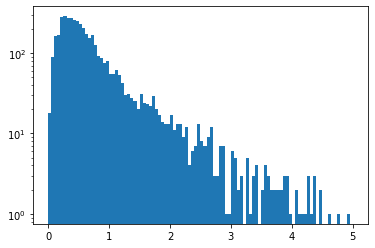

In [357]:
plt.hist(gen[:, 0], bins=np.linspace(0,5,101));
plt.yscale("log")

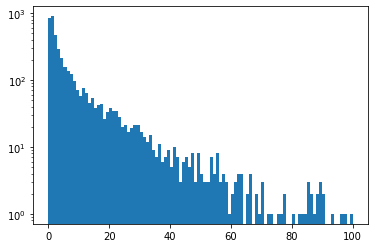

In [358]:
plt.hist(gen[:, 1], bins=np.linspace(0,100,101));
plt.yscale("log")

In [359]:
len(gen), np.sum(gen[:, 0]>0.2)

(4312, 3872)

In [360]:
fi = np.load("../ev.npz")

In [361]:
arr = fi["reco_to_gen"]
arr2 = (arr.T / reco[:, 1]).T
arr3 = arr2 > 0.2

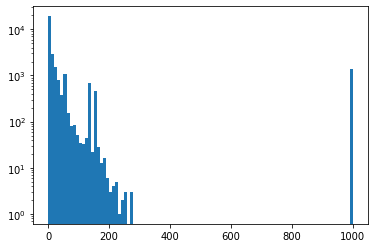

In [362]:
plt.hist(arr[arr!=0], bins=100);
plt.yscale("log")

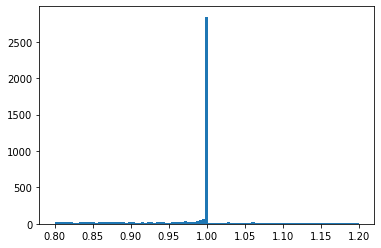

In [363]:
plt.hist(arr2[arr2!=0].flatten(), bins=np.linspace(0.8,1.2, 100));

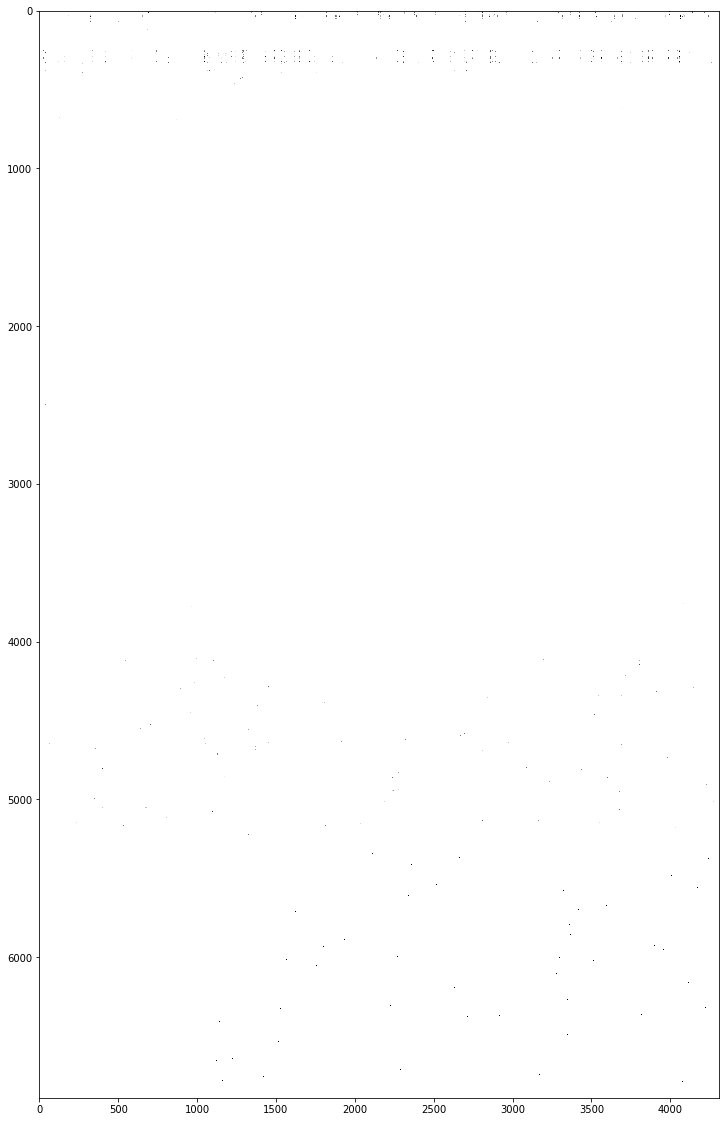

In [364]:
import matplotlib
plt.figure(figsize=(20,20))
plt.imshow(arr, cmap="Greys", norm=matplotlib.colors.LogNorm(vmin=0.5, vmax=100))

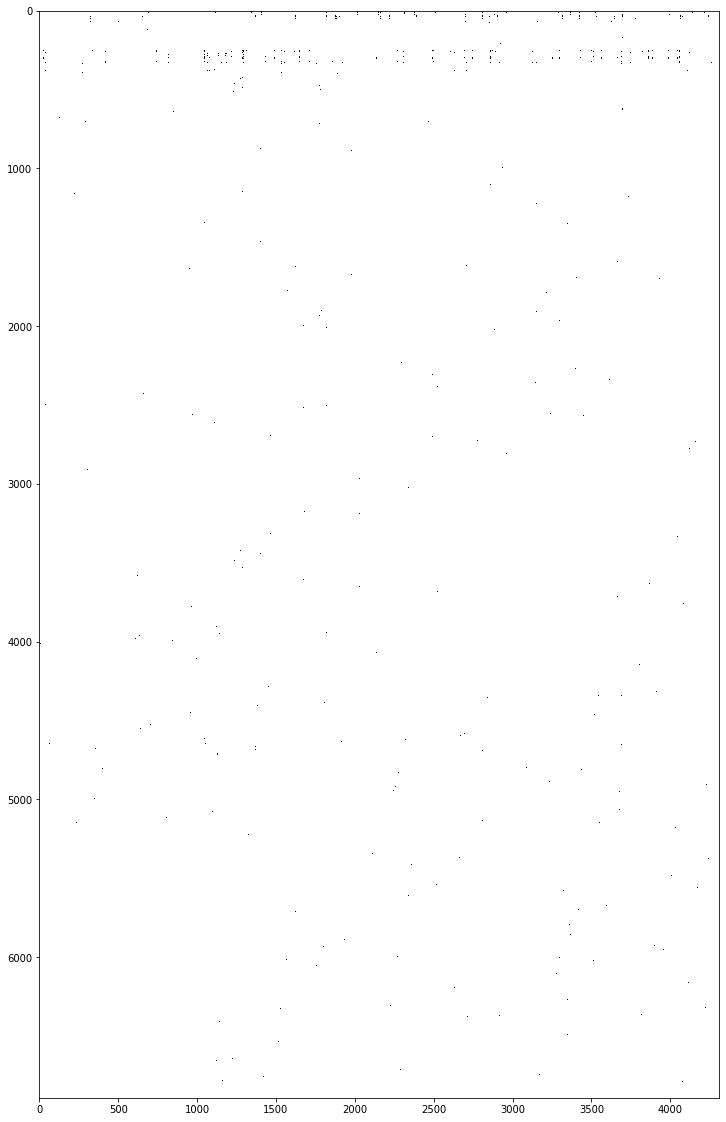

In [365]:
plt.figure(figsize=(20,20))
plt.imshow(arr3, cmap="Greys")

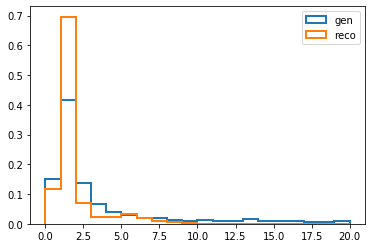

In [366]:
plt.hist(arr3.sum(axis=0), bins=np.linspace(0,20,21), histtype="step", lw=2, density=1.0, label="gen");
plt.hist(arr3.sum(axis=1), bins=np.linspace(0,20,21), histtype="step", lw=2, density=1.0, label="reco");
#plt.yscale("log")
plt.legend()

In [367]:
highest_pt_idx = np.argsort(gen[:, 0])[::-1]

In [368]:
remaining_indices = np.ones(arr.shape[0], dtype=np.int64)
pairs_reco_gen = {}
unreconstructable = []
for igen in highest_pt_idx:
    if gen[igen, 0] < 0.2:
        continue
    temp = remaining_indices*arr[:, igen]
    best_reco_idx = np.argmax(temp)
    #print(igen, best_reco_idx)
    if best_reco_idx != 0 and temp.sum()>0.0:
        #remaining_indices[best_reco_idx] = 0
        if not (best_reco_idx in pairs_reco_gen):
            pairs_reco_gen[best_reco_idx] = []
        if arr[best_reco_idx, igen] / reco[best_reco_idx, 1] > 0.2:
            pairs_reco_gen[best_reco_idx] += [(igen, arr[best_reco_idx, igen])]
    else:
        unreconstructable += [igen]

pairs_reco_gen_sorted = {}
for k, v in pairs_reco_gen.items():
    v = sorted(v, key=lambda x: x[1], reverse=True)
    pairs_reco_gen_sorted[k] = v

pairs_reco_gen = pairs_reco_gen_sorted

unreconstructable = np.array(unreconstructable)

In [369]:
pairs_reco_gen

{317: [(43, 63.18852615356445)],
 6090: [(1075, 1000.0)],
 641: [(90, 30.406993865966797), (91, 17.466508865356445)],
 321: [(84, 103.54443359375),
  (33, 92.04888153076172),
  (39, 66.12040710449219),
  (1288, 26.163013458251953)],
 6862: [(1076, 1000.0)],
 6794: [(1220, 1000.0)],
 5893: [(1073, 1000.0)],
 6609: [(3879, 1000.0)],
 6074: [(1216, 1000.0)],
 294: [(1217, 279.6009521484375),
  (69, 191.48193359375),
  (4147, 32.763545989990234)],
 6075: [(1064, 1000.0)],
 6408: [(1142, 1000.0)],
 6061: [(1066, 1000.0)],
 6795: [(1222, 1000.0)],
 272: [(41, 37.477909088134766), (3964, 17.99390983581543)],
 642: [(38, 5.977766513824463)],
 5911: [(1135, 1000.0)],
 4134: [(780, 119.5919418334961)],
 6095: [(1297, 1000.0)],
 326: [(1047, 93.95613861083984),
  (2123, 44.216766357421875),
  (3688, 26.408470153808594),
  (421, 24.26908302307129),
  (3882, 16.028972625732422),
  (1324, 14.539905548095703),
  (3484, 14.531527519226074),
  (4292, 12.487286567687988),
  (4121, 11.758237838745117)],


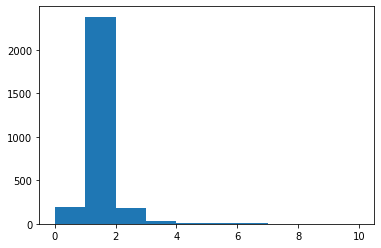

In [370]:
plt.hist([len(x[1]) for x in pairs_reco_gen.items()], np.linspace(0,10,11));

In [376]:
ir = 4435
print("rec", ir, ", ".join(["{:.4f}".format(x) for x in reco[ir]]))
for ig, cmp in pairs_reco_gen[ir]:
    print("gen", ig, ", ".join(["{:.4f}".format(x) for x in gen[ig]]), round(cmp, 2))

rec 4435 0.0000, 14.3963, -3.2388, 2.5307, 0.0000
gen 2218 0.8693, 10.2333, -3.1569, 2.3180, -211.0000 4.8
gen 3076 0.3956, 3.9540, -2.9928, 1.9395, 22.0000 4.8
